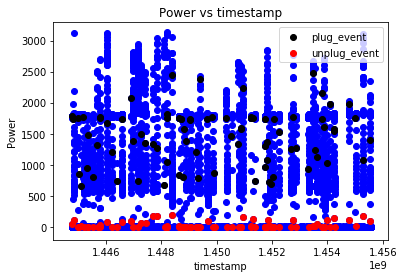

In [32]:
#import time-series from .csv file
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn import preprocessing
import time
import calendar
df1 = pd.read_csv("/home/just/Scaricati/feed_54.MYD.csv")
x = df1.iloc[:,0]           
y = df1.iloc[:,1]
%matplotlib inline
trigger_plug_x = []
trigger_unplug_x = []
trigger_plug_y = []
trigger_unplug_y = []
energy = []
durata_ricarica = []
day_hour = []
day_week = []
next_charge = []
flag_plug = 1
flag_unplug = 0
outlier_time = 0
prima_ricarica = 1
def switch_demo(argument):  #funzione che serve per mappare i giorni della settimana in numeri
    switcher = {
        "Monday": 0,
        "Tuesday": 1,
        "Wednesday": 2,
        "Thursday" : 3,
        "Friday": 4,
        "Saturday": 5,
        "Sunday": 6
    }
    return switcher.get(argument,"Invalid day of week")
lunghezza = range(1,len(x))
for n in lunghezza: #scorro tutta la time series per individuare le ricariche
    differenza = y[n] - y[n-1]  #salvo la differenza tra un valore e quello successivo
    if (differenza > 600 ) & (flag_plug == 1):    #è iniziata la ricarica
        trigger_plug_x.append(x[n])
        trigger_plug_y.append(y[n])
        if prima_ricarica == 0:
            next_charge.append((x[n] - x[fine_energia])/60)
            temp = inizio_energia
        flag_plug = 0     #sto caricando la macchina, aspetto l'unplug
        flag_unplug = 1   #riattivo il flag dell'unplug
        inizio_energia = n #salvo l'indice per cui ho trovato l'evento di plug
        if prima_ricarica == 0:
            if trigger_plug_x[-1] - trigger_unplug_x[-1] < 600:    #se c'è un falso unplug elimino i dati relativi all'ultima ricarica
                del trigger_plug_x[-1]
                del trigger_plug_y[-1]
                del trigger_unplug_x[-1]
                del trigger_unplug_y[-1]
                inizio_energia = temp
                del energy[-1]
                del day_hour[-1]
                del day_week[-1]
                del durata_ricarica[-1]
                del next_charge[-1]
               
    if (differenza < -150 and flag_unplug == 1 and y[n] < 200): #è terminata la ricarica
        trigger_unplug_x.append(x[n])
        trigger_unplug_y.append(y[n])
        flag_unplug = 0
        flag_plug = 1
        fine_energia = n
        prima_ricarica = 0
        if trigger_unplug_x[-1] - trigger_plug_x[-1] < outlier_time:   #rimuovo gli outlier
            del trigger_plug_x[-1]
            del trigger_plug_y[-1]
            del trigger_unplug_x[-1]
            del trigger_unplug_y[-1]
        else: #se non ci sono outlier la ricarica è terminata correttamente e salvo i risultati 
            energia = 0
            tot = range(0,fine_energia - inizio_energia)
            for i in (tot):    #calcolo l'energia assorbita
                energia = energia + (y[inizio_energia + i] * (x[inizio_energia + i +1] - x[inizio_energia + i]))
            energia = energia / 3600 #convert joule to Wh
            energy.append(energia)
            day_hour.append(datetime.utcfromtimestamp(x[inizio_energia]).strftime('%H'))   #calcolo l'ora in cui è iniziata la ricarica (aggiungi %M:%S per minuti e secondi)
            def convert_epoch_time_to_day_of_the_week(epoch_milliseconds):    #calcolo il giorno della settimana
                epoch = epoch_milliseconds / 1000
            day_week.append(switch_demo(time.strftime("%A", time.gmtime(x[inizio_energia]))))
            durata_ricarica.append((x[fine_energia] - x[inizio_energia])/60) #calcolo la durata della ricarica in minuti
plt.scatter(x,y,color = 'b')
plt.scatter(trigger_plug_x,trigger_plug_y,color = 'k', label = 'plug_event')
plt.scatter(trigger_unplug_x,trigger_unplug_y,color = 'r', label = 'unplug_event')
plt.title('Power vs timestamp')
plt.xlabel('timestamp')
plt.ylabel('Power')
plt.legend(loc = 'upper right')
plt.show()
next_charge.append(0)
data = pd.DataFrame({'Energia assorbita (Wh)' : energy, 'Day_hour' : day_hour, 'Day_week': day_week, 'Durata ricarica (minuti)': durata_ricarica, 'Next charge (minuti)' : next_charge})
data.to_csv("/home/just/Scaricati/export.csv", index = False) #sostituire il path nel quale si vuole esportare il file
